## MLPP HW1 - Diagnostic - Part 2

### Data Augmentation using ACS API

In [1]:
import warnings
warnings.simplefilter('ignore')

%run helper.py
%matplotlib inline

To limit API calls, I limited the datasets to the last three months. I wrote a handful of helper functions to append a FIPS code to a row in the data based on latitude and longitude and to append a census tract's income, family size, health care coverage, and unemployment rate to the dataframe. Then I saved the augmented data to a pickle file. 

In [2]:
#buildings = three_months('vacant_buildings_17.pkl', 'DATE SERVICE REQUEST WAS RECEIVED')
#lights = three_months('alley_lights_17.pkl')

#buildings = scrape_fips_blocks(buildings)
#lights = scrape_fips_blocks(lights)

#buildings = scrape_acs(buildings)
#lights = srapce_acs(lights)

buildings = pd.read_pickle('buildings_acs.pkl')
lights = pd.read_pickle('lights_acs.pkl')

# drop 0 values
buildings = drop_if(buildings, col_list=['Ward', 'ZIP CODE', 'Police District', 'Community Area'])
lights = drop_if(lights)

I obtained the means for the demographic data and plot the distirbutions at the zip code level. Originally, I thought to aggregate at the community area level, but there are actually 57 areas while there are 45 zip codes. 

In [3]:
# building requests
income_dist_1 = pd.DataFrame(buildings['avg_monthly_income'].groupby(buildings['ZIP CODE']).describe()['mean'].sort_values(ascending=True,inplace=False))
fam_size_dist_1 = pd.DataFrame(buildings['avg_family_size'].groupby(buildings['ZIP CODE']).describe()['mean'].sort_values(ascending=True,inplace=False))
health_cov_dist_1 = pd.DataFrame(buildings['pct_health_coverage'].groupby(buildings['ZIP CODE']).describe()['mean'].sort_values(ascending=True,inplace=False))
unemployment_dist_1 = pd.DataFrame(buildings['unemployment_rate'].groupby(buildings['ZIP CODE']).describe()['mean'].sort_values(ascending=True,inplace=False))

In [ ]:
# light requests
income_dist_2 = pd.DataFrame(lights['avg_monthly_income'].groupby(lights['ZIP Code']).describe()['mean'].sort_values(ascending=True,inplace=False))
fam_size_dist_2 = pd.DataFrame(lights['avg_family_size'].groupby(lights['ZIP Code']).describe()['mean'].sort_values(ascending=True,inplace=False))
health_cov_dist_2 = pd.DataFrame(lights['pct_health_coverage'].groupby(lights['ZIP Code']).describe()['mean'].sort_values(ascending=True,inplace=False))
unemployment_dist_2 = pd.DataFrame(lights['unemployment_rate'].groupby(lights['ZIP Code']).describe()['mean'].sort_values(ascending=True,inplace=False))

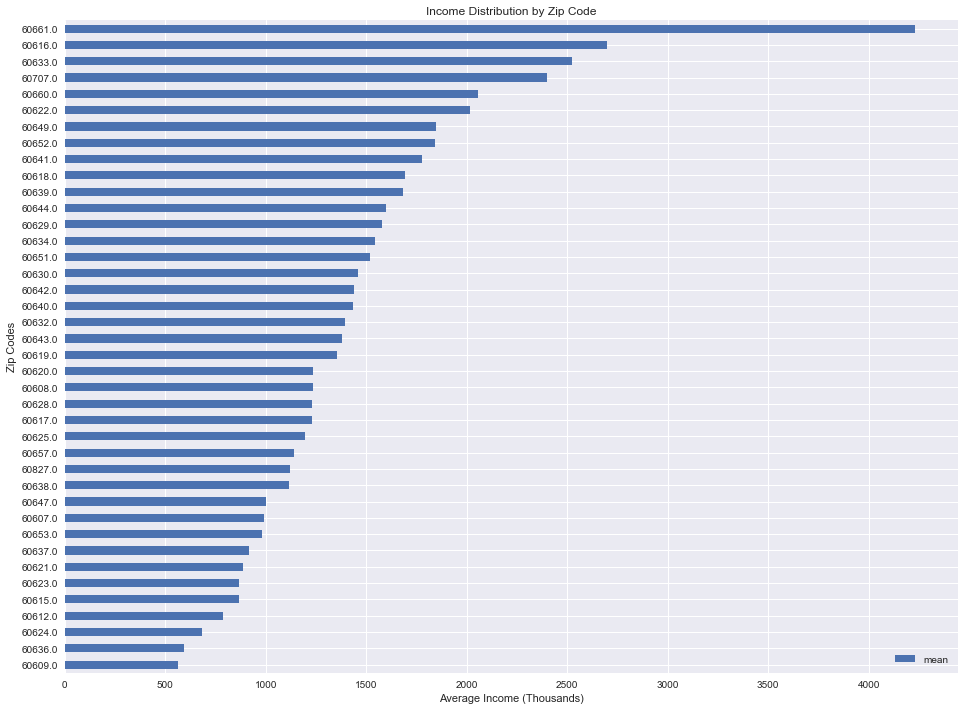

In [4]:
plot_dist(income_dist_1, 'Income Distribution by Zip Code', 'Average Income (Thousands)')

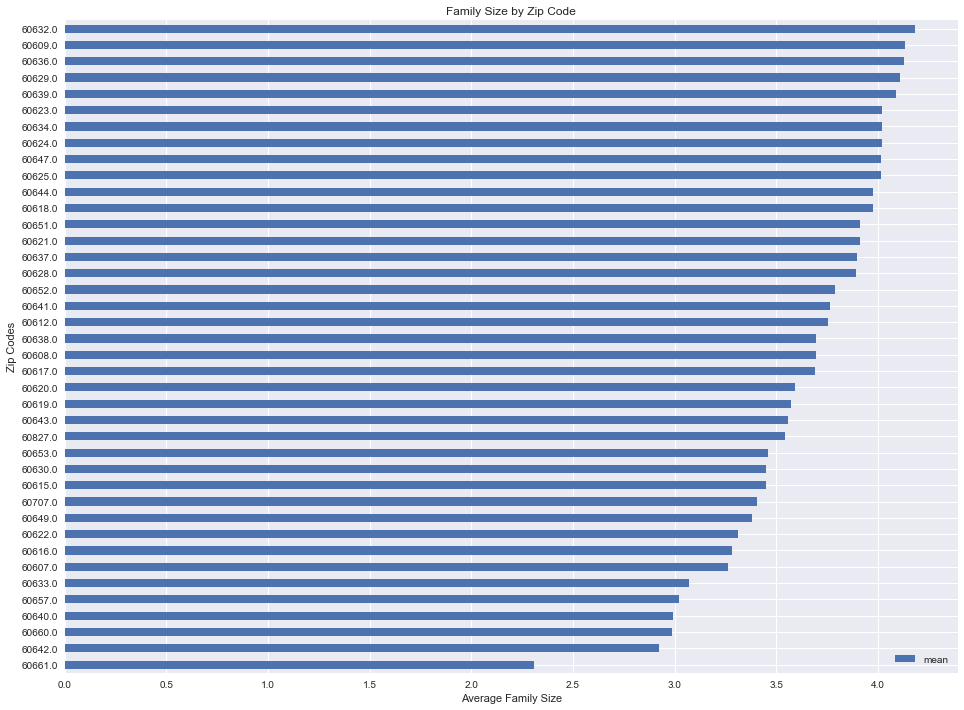

In [5]:
plot_dist(fam_size_dist_1, 'Family Size by Zip Code', 'Average Family Size')

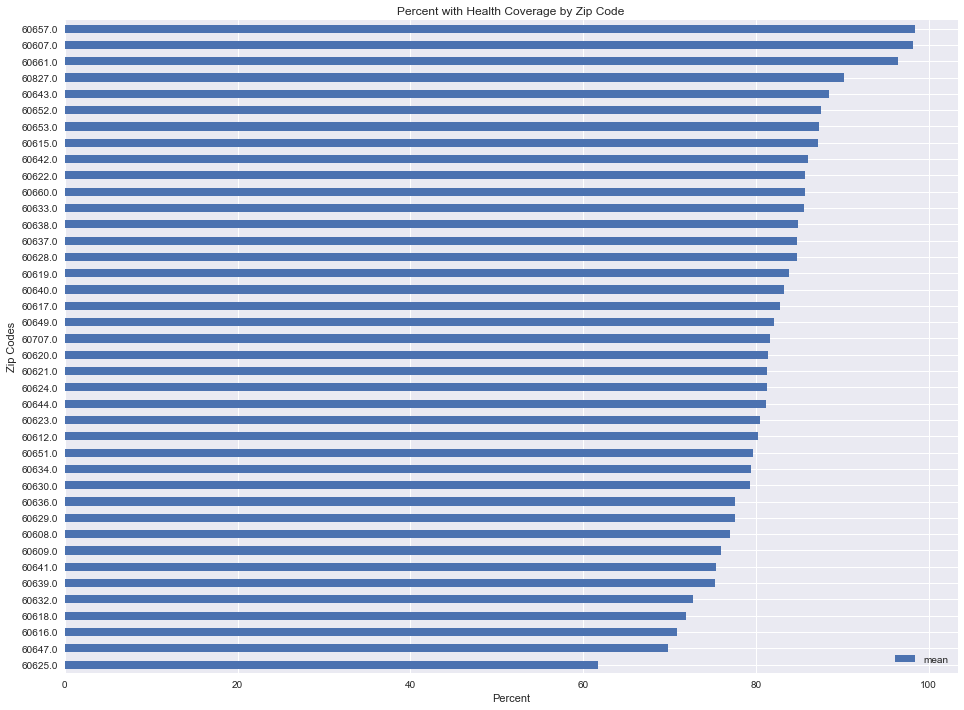

In [6]:
plot_dist(health_cov_dist_1, 'Percent with Health Coverage by Zip Code', 'Percent')

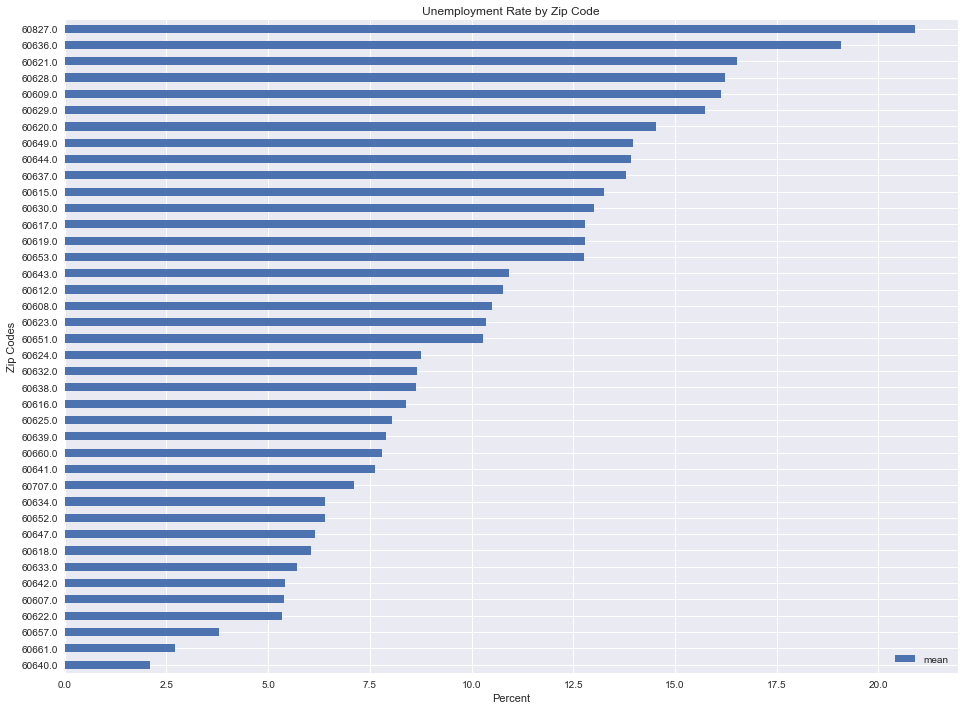

In [7]:
plot_dist(unemployment_dist_1, 'Unemployment Rate by Zip Code', 'Percent')

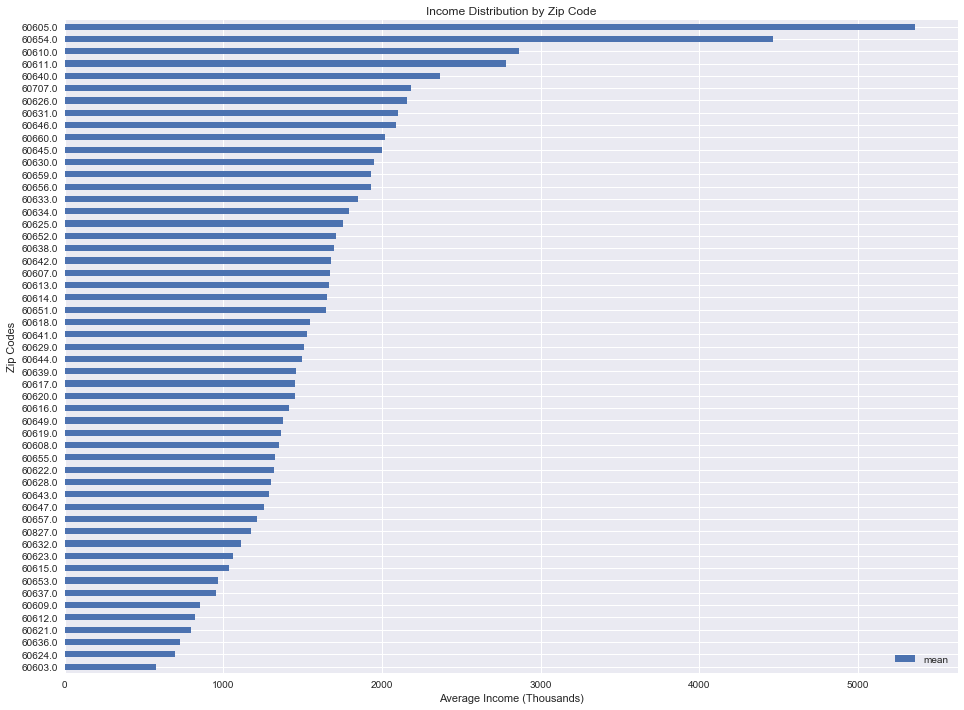

In [9]:
plot_dist(income_dist_2, 'Income Distribution by Zip Code', 'Average Income (Thousands)')

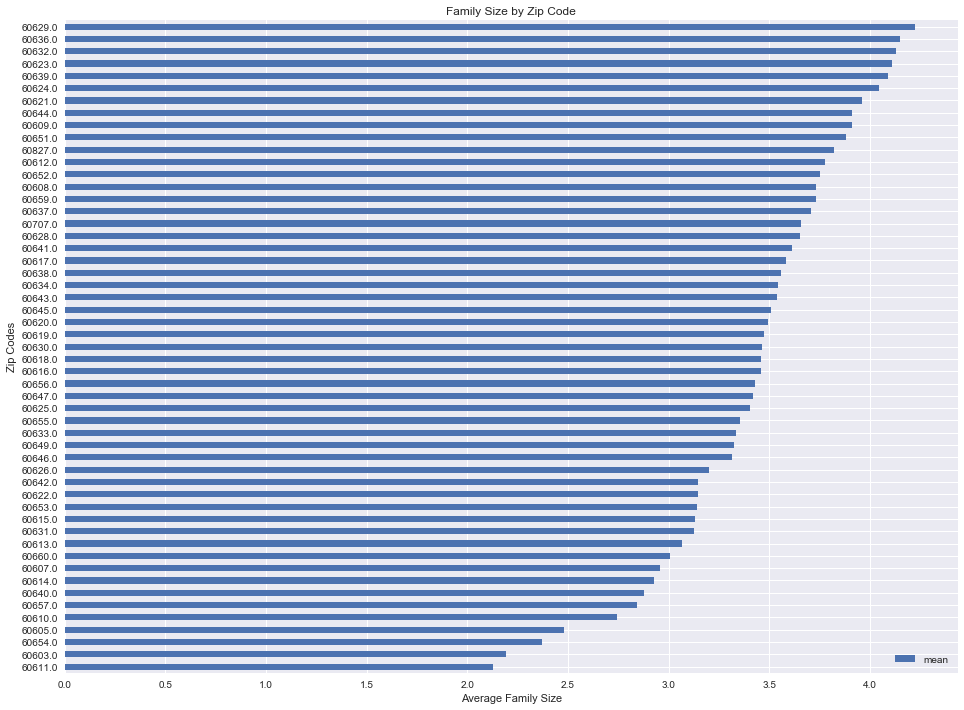

In [10]:
plot_dist(fam_size_dist_2, 'Family Size by Zip Code', 'Average Family Size')

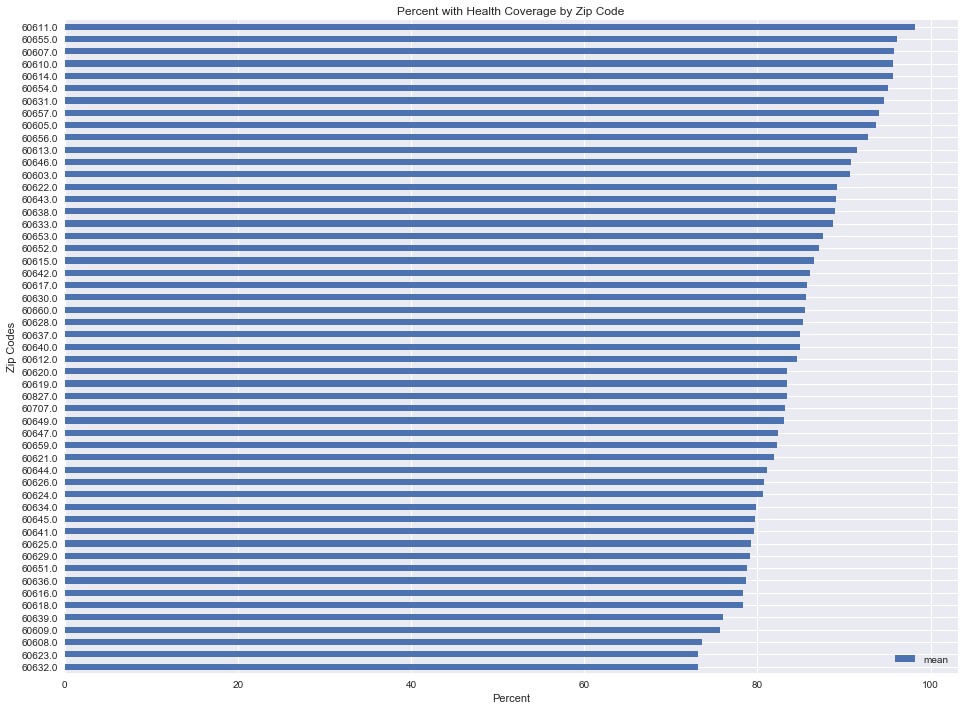

In [11]:
plot_dist(health_cov_dist_2, 'Percent with Health Coverage by Zip Code', 'Percent')

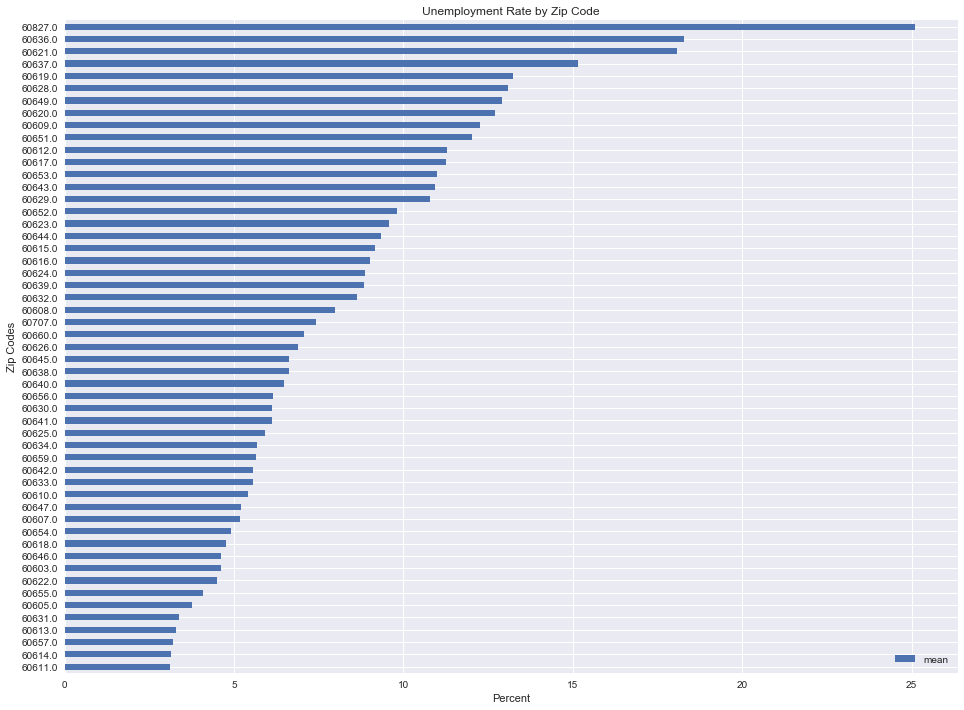

In [12]:
plot_dist(unemployment_dist_2, 'Unemployment Rate by Zip Code', 'Percent')